In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:34221' processes=5 threads=90, memory=419.10 GiB>

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

In [4]:
# cfg_var_photoC_TOT_zint_100m=CESM2_config()
# cfg_var_photoC_TOT_zint_100m.year_s=1850
# cfg_var_photoC_TOT_zint_100m.year_e=2024
# cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')

# cfg_var_TAUX=CESM2_config()
# cfg_var_TAUX.year_s=1850
# cfg_var_TAUX.year_e=2024
# cfg_var_TAUX.setvar('TAUX')

# cfg_var_TAUY=CESM2_config()
# cfg_var_TAUY.year_s=1850
# cfg_var_TAUY.year_e=2024
# cfg_var_TAUY.setvar('TAUY')

# cfg_var_NO3=CESM2_config()
# cfg_var_NO3.year_s=1850
# cfg_var_NO3.year_e=2024
# cfg_var_NO3.setvar('NO3')

# cfg_var_Fe=CESM2_config()
# cfg_var_Fe.year_s=1850
# cfg_var_Fe.year_e=2024
# cfg_var_Fe.setvar('Fe')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1850
cfg_var_TEMP.year_e=2024
cfg_var_TEMP.setvar('TEMP')

# cfg_var_SSH=CESM2_config()
# cfg_var_SSH.year_s=1850
# cfg_var_SSH.year_e=2024
# cfg_var_SSH.setvar('SSH')

# cfg_var_HBLT=CESM2_config()
# cfg_var_HBLT.year_s=1850
# cfg_var_HBLT.year_e=2024
# cfg_var_HBLT.setvar('HBLT')


if cfg_var_TEMP.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')



In [5]:
#thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N (h), that is, the
# WWV index (with a constant factor of the area it covers).

cut_grid_info = {
    "lonw": 120,
    "lone": 280,
    "lats": -5,
    "latn": 5
}

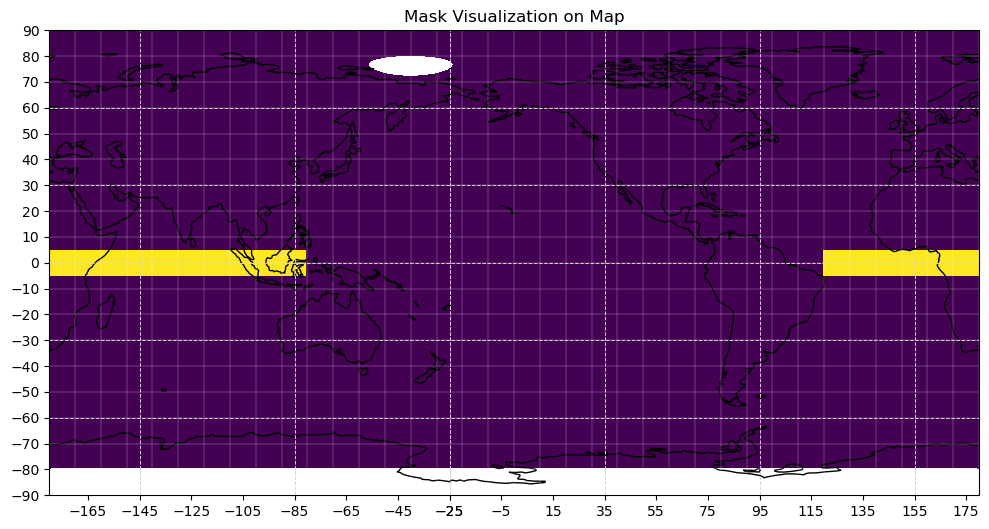

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import numpy as np

cut_grid_info = {
    "lonw": 120,
    "lone": 280,
    "lats": -5,
    "latn": 5
}


# 경도/위도 포매터 직접 정의
def lon_formatter(x, pos):
    return f"{abs(int(x))}°{'E' if x >= 0 else 'W'}"

def lat_formatter(x, pos):
    return f"{abs(int(x))}°{'N' if x >= 0 else 'S'}"

ds = ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))

fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=205)},
    figsize=(12, 8)
)

# Mask plot
pc = ax.pcolormesh(
    ds.TLONG, ds.TLAT, mask.astype(int),
    transform=ccrs.PlateCarree(central_longitude=205),
    cmap='viridis'
)

ax.coastlines()
# plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')

# ----------------------------
#  Fine-grid cartopy plot code
# ----------------------------

lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

# 그릴 grid 라인 간격
minor_step = 10   # 더 fine하게 하고 싶으면 1 또는 0.5 가능
major_step_lon = 20
major_step_lat = 10

# major ticks (20°, 10°)
ax.set_xticks(np.arange(lon_min, lon_max+1, major_step_lon), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max+1, major_step_lat), crs=ccrs.PlateCarree())

# major gridlines
ax.gridlines(draw_labels=False, linewidth=0.7, color="lightgray", linestyle="--")

# ==========================================
# 직접 minor gridlines 생성하여 그림
# ==========================================
# 1) 경도 minor
minor_lons = np.arange(lon_min, lon_max+1, minor_step)

for x in minor_lons:
    ax.plot([x, x], [lat_min, lat_max],
            transform=ccrs.PlateCarree(central_longitude=205),
            color="white", linewidth=0.25, alpha=0.7)

# 2) 위도 minor
minor_lats = np.arange(lat_min, lat_max+1, minor_step)

for y in minor_lats:
    ax.plot([lon_min, lon_max], [y, y],
            transform=ccrs.PlateCarree(central_longitude=205),
            color="white", linewidth=0.25, alpha=0.7)

plt.show()


In [23]:
cfg_var_photoC_TOT_zint_100m=CESM2_config()
cfg_var_photoC_TOT_zint_100m.year_s=1850
cfg_var_photoC_TOT_zint_100m.year_e=2024
cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')

In [28]:


exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_photoC_TOT_zint_100m.var]


def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))

    # area = ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * area).sum(dim=['nlat','nlon'], skipna=True)
    # effective_area = area.where(ds[varname].notnull()).sum(dim=['nlat','nlon'], skipna=True)
    # ds[varname] = weighted_sum / effective_area
    
    volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [30]:
# Read Observation dataset (NPP)
start_time = time.time()
# photoC_TOT_zint_100m
cfg_var_photoC_TOT_zint_100m.OBS_path_load(cfg_var_photoC_TOT_zint_100m.var)
dname=cfg_var_photoC_TOT_zint_100m.OBS_var
cfg_var_photoC_TOT_zint_100m.OBS_ds = xr.open_mfdataset(
    cfg_var_photoC_TOT_zint_100m.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.rename({cfg_var_photoC_TOT_zint_100m.OBS_var: cfg_var_photoC_TOT_zint_100m.var})

# new_time = cfg_var_photoC_TOT_zint_100m.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_TOT_zint_100m.OBS_ds.time))
# cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=new_time)

# if cfg_var_photoC_TOT_zint_100m.var=='SSH':
#     cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[396:732]) #1993~2020
# elif cfg_var_photoC_TOT_zint_100m.var=='photoC_TOT_zint_100m':
#     cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[456:732]) #1999~2020
# elif cfg_var_photoC_TOT_zint_100m.var=='FG_CO2':
#     cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[264:732])

cfg_var_photoC_TOT_zint_100m.OBS_ds.time

# global mean removal for SSH
if cfg_var_photoC_TOT_zint_100m.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_photoC_TOT_zint_100m.OBS_ds[cfg_var_photoC_TOT_zint_100m.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_photoC_TOT_zint_100m.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_photoC_TOT_zint_100m.OBS_ds['SSH'] = cfg_var_photoC_TOT_zint_100m.OBS_ds[cfg_var_photoC_TOT_zint_100m.var] - cfg_var_photoC_TOT_zint_100m.OBS_ds['gm']


# cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.where(mask, drop=True)
# area = ds_grid_sub['TAREA']
# weighted_sum = (cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'] * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
# cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))


elasped time for reading OBS: 26.877610206604004


In [32]:
NPP_mean = cfg_var_photoC_TOT_zint_100m.OBS_ds.mean(dim='time').compute()

In [43]:
import xarray as xr
import numpy as np
from scipy import signal

ds = cfg_var_photoC_TOT_zint_100m.OBS_ds
var = ds["photoC_TOT_zint_100m"]

# -------------------------------
# 1) Monthly climatology remove
# -------------------------------
clim = var.groupby("time.month").mean("time")
da_anom = var.groupby("time.month") - clim

# -------------------------------
# Fix: rechunk time to single chunk
# -------------------------------
da_anom = da_anom.chunk({"time": -1})

# -------------------------------
# 2) Linear detrend
# -------------------------------
da_detrended = xr.apply_ufunc(
    signal.detrend,
    da_anom,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    kwargs={"axis": 0, "type": "linear"},
)

# -------------------------------
# 3) std
# -------------------------------
NPP_std = da_detrended.std("time").compute()
NPP_std


ValueError: array must not contain infs or NaNs

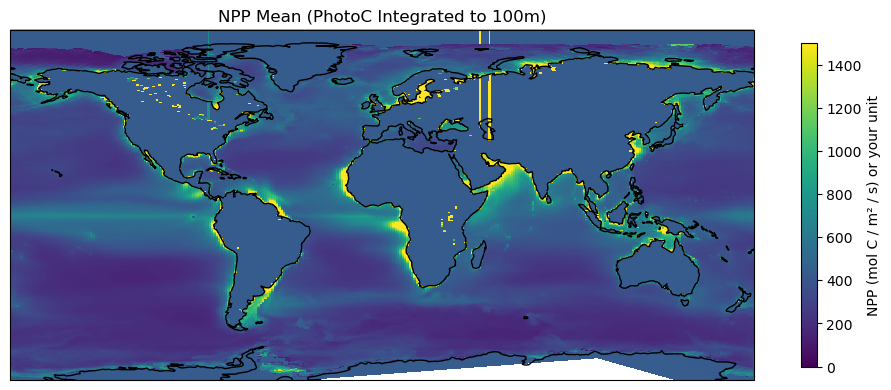

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ds = NPP_mean   # 또는 네가 변수명을 어떻게 할당했는지에 따라 조정

fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# 데이터 변수 이름 확인 필요 → photoC_TOT_zint_100m
var = ds["photoC_TOT_zint_100m"]

# 플롯
pcm = ax.pcolormesh(
    ds["TLONG"], ds["TLAT"], var,
    cmap="viridis",
    transform=ccrs.PlateCarree(), vmin=0, vmax=1500
)

ax.coastlines()
cbar = plt.colorbar(pcm, ax=ax, shrink=0.7)
cbar.set_label("NPP (mol C / m² / s) or your unit")

plt.title("NPP Mean (PhotoC Integrated to 100m)")
plt.show()


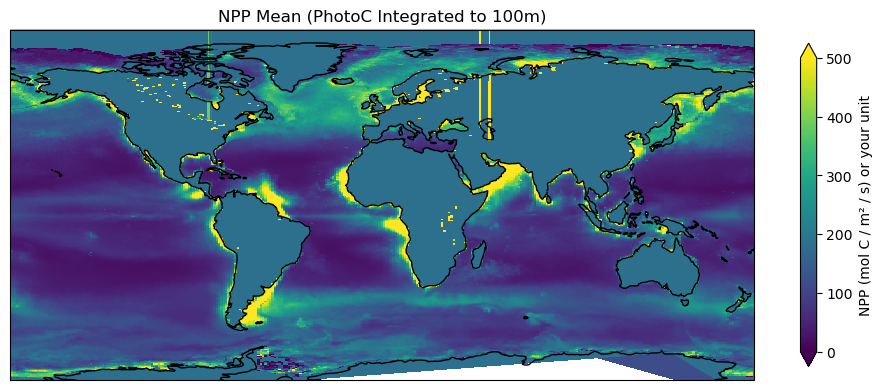

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ds = NPP_std   # 또는 네가 변수명을 어떻게 할당했는지에 따라 조정

fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# 데이터 변수 이름 확인 필요 → photoC_TOT_zint_100m
var = ds["photoC_TOT_zint_100m"]

# 플롯
pcm = ax.pcolormesh(
    ds["TLONG"], ds["TLAT"], var,
    cmap="viridis",
    transform=ccrs.PlateCarree(), vmin=0, vmax=500
)

ax.coastlines()
cbar = plt.colorbar(pcm, ax=ax, shrink=0.7, extend='both')
cbar.set_label("NPP (mol C / m² / s) or your unit")

plt.title("NPP Mean (PhotoC Integrated to 100m)")
plt.show()
